In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json

import signature.tensor_algebra as ta
from signature.pricing.models.sig_vol import SigVol

from pricing.products.vanilla_option import VanillaOption
from pricing.models.model_params import LewisParams, MCParams
from pricing.utility import from_1_delta_call_to_strike

from simulation.monte_carlo import MonteCarlo

my_green = "#5b6c64"
my_copper = "#B56246"
color_cycle = [my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"] 
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
N = 8
dim = 3
e = ta.AlgebraBasis(dim=2, trunc=N)
e_3d = ta.AlgebraBasis(dim=dim, trunc=N)

### Payoffs

In [3]:
from scipy.stats import norm

def call_payoff(F, K):
    return np.maximum(F - K, 0)

def digital_call_payoff(F, K):
    return (F - K >= 0).astype(float)

#### Localization

$$\mathrm{Payoff}(x) = F(x) + G(x),$$

where $F$ is irregular with a compact support and $G$ is smooth.

## Vanilla option

#### A decomposition from "Applications of Malliavin calculus to Monte Carlo methods in finance"

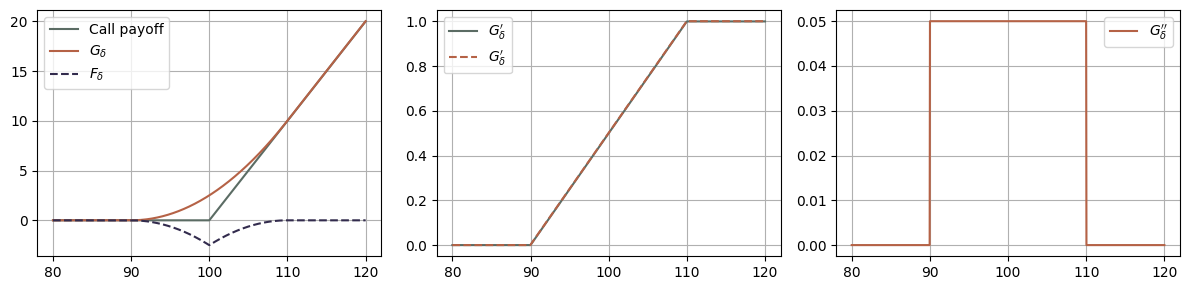

In [4]:
F0 = 100
delta = 10
F_grid = np.linspace(80, 120, 1000)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

H_delta = lambda x, K: (x - (K - delta)) / (2 * delta) * (x >= K - delta) * (x <= K + delta) + (x > K + delta)
H_delta_prime = lambda x, K: 1 / (2 * delta) * (x >= K - delta) * (x <= K + delta)
F_delta = lambda x, K: (-(x - (K - delta))**2 / (4 * delta)) * (x >= K - delta) * (x < K) + \
                       (-(x - (K + delta))**2 / (4 * delta)) * (x >= K) * (x < K + delta)


ax[0].plot(F_grid, call_payoff(F_grid, K=F0), label="Call payoff")
ax[0].plot(F_grid, np.cumsum(H_delta(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[0].plot(F_grid, F_delta(F_grid, K=F0), "--", label="$F_\delta$")
ax[0].legend()

ax[1].plot(F_grid, H_delta(F_grid, K=F0), label="$G_\delta'$")
ax[1].plot(F_grid, np.cumsum(H_delta_prime(F_grid, K=F0) * (F_grid[1] - F_grid[0])), "--", label="$G_\delta'$")
ax[1].legend()

ax[2].plot(F_grid, H_delta_prime(F_grid, K=F0), label="$G_\delta''$", color=my_copper)
ax[2].legend()

#### Smooth decomposition

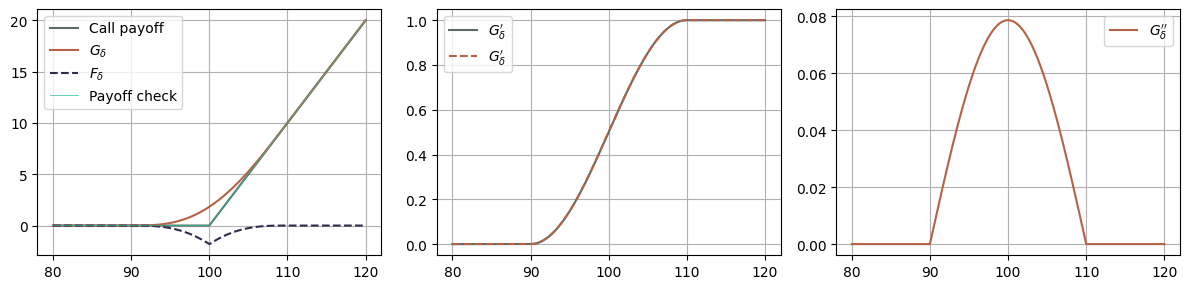

In [5]:
F0 = 100
delta = 10
F_grid = np.linspace(80, 120, 1000)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

H_delta = lambda x, K: (0.5 + 0.5 * np.sin(0.5 * np.pi * (x - K) / delta)) * (x >= K - delta) * (x <= K + delta) + (x > K + delta)
H_delta_prime = lambda x, K: 0.25 * np.pi / delta * np.cos(0.5 * np.pi * (x - K) / delta) * (x >= K - delta) * (x <= K + delta) 
F_delta = lambda x, K: (np.maximum(x - K, 0) - 0.5 * (x - K + delta) - delta / np.pi * np.cos(np.pi * x / 2 / delta)) * (x >= K - delta) * (x <= K + delta) 

ax[0].plot(F_grid, call_payoff(F_grid, K=F0), label="Call payoff")
ax[0].plot(F_grid, np.cumsum(H_delta(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[0].plot(F_grid, F_delta(F_grid, K=F0), "--", label="$F_\delta$")
ax[0].plot(F_grid, F_delta(F_grid, K=F0) + np.cumsum(H_delta(F_grid, K=F0) * (F_grid[1] - F_grid[0])), "-", lw=0.5, label="Payoff check")
ax[0].legend()

ax[1].plot(F_grid, H_delta(F_grid, K=F0), label="$G_\delta'$")
ax[1].plot(F_grid, np.cumsum(H_delta_prime(F_grid, K=F0) * (F_grid[1] - F_grid[0])), "--", label="$G_\delta'$")
ax[1].legend()

ax[2].plot(F_grid, H_delta_prime(F_grid, K=F0), label="$G_\delta''$", color=my_copper)
ax[2].legend()

## Digital option

#### A decomposition from "Applications of Malliavin calculus to Monte Carlo methods in finance"

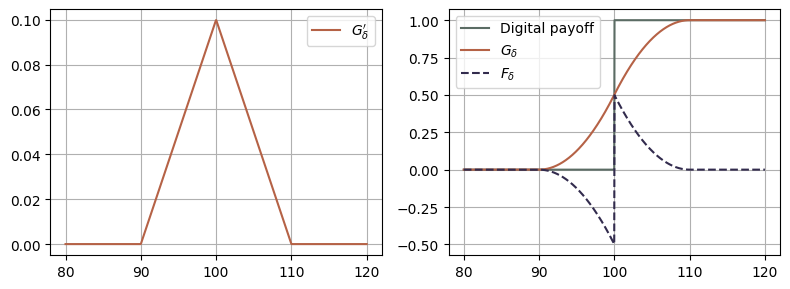

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

H_delta_dig = lambda x, K: (x - (K - delta)) / delta**2 * (x >= K - delta) * (x <= K) + \
                           ((K + delta) - x) / delta**2 * (x > K) * (x <= K + delta)
H_delta_prime_dig = lambda x, K: 1 / delta**2 * (x >= K - delta) * (x <= K) - 1 / delta**2 * (x > K) * (x <= K + delta)
G_delta_dig = lambda x, K: ((x - (K - delta))**2 / (2 * delta**2)) * (x >= K - delta) * (x < K) + \
                           (1 - ((x - (K + delta))**2 / (2 * delta**2))) * (x >= K) * (x < K + delta) + (x >= K + delta)
F_delta_dig = lambda x, K: digital_call_payoff(x, K=K) - G_delta_dig(x, K=K)

ax[0].plot(F_grid, H_delta_dig(F_grid, K=F0), label="$G_\delta'$", color=my_copper)
ax[0].legend()

ax[1].plot(F_grid, digital_call_payoff(F_grid, K=F0), label="Digital payoff")
ax[1].plot(F_grid, np.cumsum(H_delta_dig(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[1].plot(F_grid, F_delta_dig(F_grid, K=F0), "--", label="$F_\delta$")

ax[1].legend()

#### Smooth decomposition

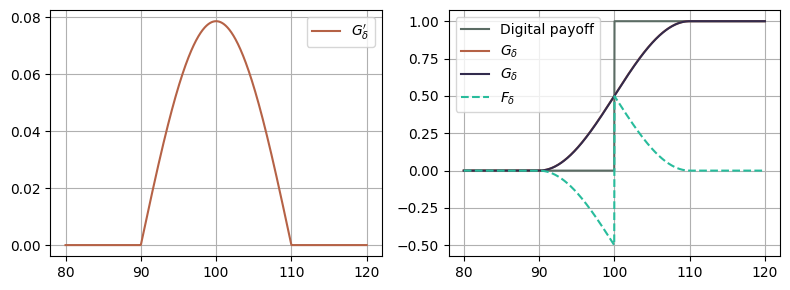

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

H_delta_dig = lambda x, K: np.pi / delta / 4 * np.cos(0.5 * np.pi * (x - K) / delta) * (x >= K - delta) * (x <= K + delta)
H_delta_prime_dig = lambda x, K: -(np.pi / delta)**2 / 8 * np.sin(0.5 * np.pi * (x - K) / delta) * (x >= K - delta) * (x <= K + delta)
G_delta_dig = lambda x, K: 0.5 * (1 + np.sin(0.5 * np.pi * (x - K) / delta)) * (x >= K - delta) * (x <= K + delta) + (x >= K + delta)
F_delta_dig = lambda x, K: digital_call_payoff(x, K=K) - G_delta_dig(x, K=K)

ax[0].plot(F_grid, H_delta_dig(F_grid, K=F0), label="$G_\delta'$", color=my_copper)
ax[0].legend()

ax[1].plot(F_grid, digital_call_payoff(F_grid, K=F0), label="Digital payoff")
ax[1].plot(F_grid, np.cumsum(H_delta_dig(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[1].plot(F_grid, G_delta_dig(F_grid, K=F0), label="$G_\delta$")
ax[1].plot(F_grid, F_delta_dig(F_grid, K=F0), "--", label="$F_\delta$")

ax[1].legend()

#### Model specification

In [8]:
%%time
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2)

CPU times: total: 8.31 s
Wall time: 10.2 s


In [9]:
%%time
shuffle_table_3d = ta.get_shuffle_table(table_trunc=N, dim=dim)

CPU times: total: 15.2 s
Wall time: 15.9 s


In [11]:
rho = -0.9
coefs = {
    0: 0.25,
    2: 0.05,
    12: 0.05,
    21: 0.05
}
vol_ts = e[0] * 0
vol_ts_3d = e_3d[0] * 0
for v, c in coefs.items():
    vol_ts += e[v] * c
    vol_ts_3d += e_3d[v] * c

print(vol_ts)
print(vol_ts_3d)

model = SigVol( 
    vol_ts=vol_ts,  
    rho=rho,
    shuffle_table=shuffle_table
)

0.25*0 + 0.05*2 + 0.05*12 + 0.05*21
0.25*0 + 0.05*2 + 0.05*12 + 0.05*21


#### Time grid specification

In [12]:
T = 0.5

N_grid = 51
t_grid = np.linspace(0, T, N_grid)

Text(0.5, 1.0, 'Vol trajectories')

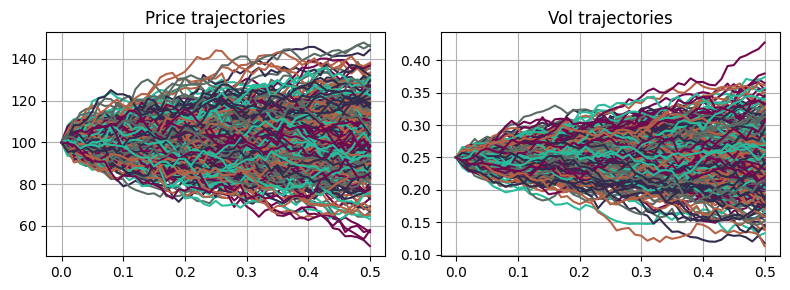

In [13]:
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=300, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

#### Simulating prices, volatilities, and signatures...

In [14]:
%%time
size = 10**4
confidence = 0.95

rng = np.random.default_rng(seed=21)
model.get_vol_trajectory(t_grid=t_grid, size=size, rng=rng)
prices, vols, bm, sig = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, 
                                                   return_vol=True, return_bm=True, return_sig=True)

rho_bar = np.sqrt(1 - model.rho**2)

B = bm[:, 0, :]
W = bm[:, 1, :]
W_ort = (B - model.rho * W) / rho_bar

CPU times: total: 7.16 s
Wall time: 7.69 s


In [15]:
%%time
if dim == 2:
    sig_full = sig
else:
    path = np.zeros((t_grid.size, 3, size))
    path[:, 0, :] = np.reshape(t_grid, (-1, 1))
    path[:, 1, :] = W.T
    path[:, 2, :] = W_ort.T
    sig_full = ta.path_to_signature(path=path, trunc=model.vol_ts.trunc, only_terminal_sig=True)

CPU times: total: 3min 23s
Wall time: 5min 56s


## Payoff specification

In [29]:
option_type = "vanilla" # "vanilla" or "digital"
is_asian = True

if option_type == "vanilla":
    payoff = call_payoff
    H = H_delta
    H_prime = H_delta_prime
    F = F_delta
elif option_type == "digital":
    payoff = digital_call_payoff
    H = H_delta_dig
    H_prime = H_delta_prime_dig
    F = F_delta_dig
else:
    raise ValueError("Incorrect option type was given")

## Malliavin weights

In [17]:
%%time
# Sigvol with rho = -1
vol_ts_squared_3d = ta.shuffle_pow(vol_ts_3d, 2, shuffle_table_3d)

CPU times: total: 62.5 ms
Wall time: 560 ms


In [18]:
%%time
ell_X = (e_3d[0] * np.log(F0) +
         ta.tensor_prod_word(vol_ts_squared_3d,  1) +
         (ta.tensor_prod_word(vol_ts_3d, 2) - ta.tensor_prod_word(vol_ts_3d.proj(2), 1) * 0.5) * rho +
         (ta.tensor_prod_word(vol_ts_3d, 3) - ta.tensor_prod_word(vol_ts_3d.proj(3), 1) * 0.5) * rho_bar
)
# ell_X = ta.tensor_prod_word(ell_X, 1) / T # in the Geometric Asian case
print(ell_X)

4.605170185988092*0 + 0.085*1 + -0.225*2 + 0.10897247358851682*3 + 0.022500000000000003*11 + 0.025*21 + -0.045000000000000005*22 + 0.021794494717703367*23 + 0.025*121 + -0.045000000000000005*122 + 0.021794494717703367*123 + 0.025*211 + -0.045000000000000005*212 + 0.021794494717703367*213 + 0.005000000000000001*221 + 0.010000000000000002*1221 + 0.010000000000000002*2121 + 0.010000000000000002*2211 + 0.010000000000000002*11221 + 0.010000000000000002*12121 + 0.010000000000000002*12211 + 0.010000000000000002*21121 + 0.010000000000000002*21211 + 0.010000000000000002*22111
CPU times: total: 859 ms
Wall time: 1.44 s


In [19]:
ell_s = ta.shuffle_exp(ell_X, shuffle_table_3d)

In [20]:
stocks_sig = ell_s @ sig_full
ell_asian = ta.tensor_prod_word(ell_s, 1) / T

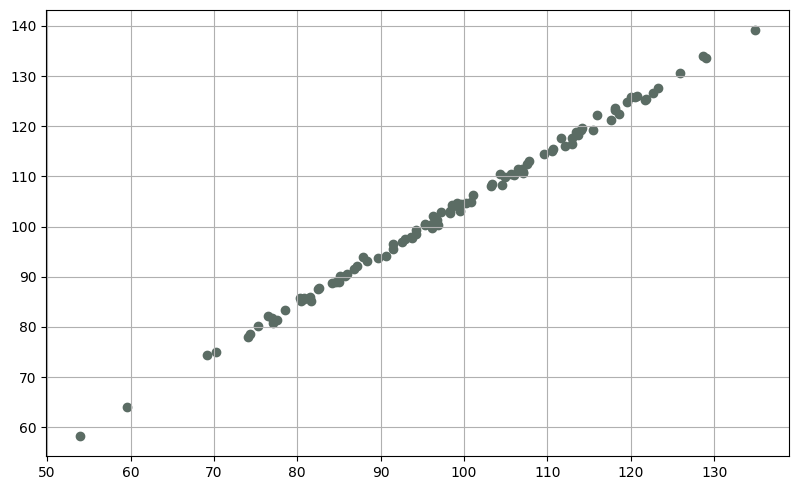

In [21]:
plt.scatter(prices[:100, -1], stocks_sig[:100])

fig, ax = plt.subplots(figsize=(5, 4))
for i, price in enumerate(prices[:3]):
    ax.plot(t_grid, np.log(price))
    ax.plot(t_grid, ((ell_X @ sig_full)[:, i]), "--")
ax.set_title("Price trajectories")

In [47]:
%%time
from signature.signature.operators import diamond, Psi

psi_ell_x = Psi(ts=ell_X, word_upper=2, word_lower=1)
double_psi_ell_x = Psi(ts=psi_ell_x, word_upper=2, word_lower=1)
lam_minus_psi_ell_x = Psi(ell_X, 2, 2) + Psi(ell_X, word_upper=22, word_lower=1) * (-1)
diamond_ell_x = diamond(ell_X, ell_X, letter_upper=2, letter_lower=1, shuffle_table=shuffle_table_3d)
double_diamond_ell_x = diamond(ell_X, diamond_ell_x, letter_upper=2, letter_lower=1, shuffle_table=shuffle_table_3d)


ts_int_vol = ta.tensor_prod_word(vol_ts_3d, 1)
ts_int_var = ta.tensor_prod_word(vol_ts_squared_3d,  1)
ts_Z_ort = ta.tensor_prod_word(vol_ts_3d, 3) - ta.tensor_prod_word(vol_ts_3d.proj(3), 1) * 0.5

CPU times: total: 0 ns
Wall time: 324 ms


In [48]:
%%time
sig_T = sig_full

psi_ell_x_sig_T = psi_ell_x @ sig_T
double_psi_ell_x_sig_T = double_psi_ell_x @ sig_T
lam_minus_psi_ell_x_sig_T = lam_minus_psi_ell_x @ sig_T
diamond_ell_x_sig_T = diamond_ell_x @ sig_T
double_diamond_ell_x_sig_T = double_diamond_ell_x @ sig_T

integrated_vol = ts_int_vol @ sig_T
integrated_var = ts_int_var @ sig_T
Z_ort = ts_Z_ort @ sig_T

CPU times: total: 172 ms
Wall time: 215 ms


In [22]:
%%time
malliavin_weights_delta = {}
malliavin_weights_gamma = {}

malliavin_weights_delta["h^1"] = (1 / F0) * (W[:, -1] / psi_ell_x_sig_T) + double_psi_ell_x_sig_T / F0 / psi_ell_x_sig_T**2

malliavin_weights_delta["h^2"] = lam_minus_psi_ell_x_sig_T / F0 / diamond_ell_x_sig_T + double_diamond_ell_x_sig_T / F0 / diamond_ell_x_sig_T**2

malliavin_weights_delta["h^3"] =  W_ort[:, -1] / rho_bar / F0 / integrated_vol

malliavin_weights_delta["h^4"] =  Z_ort / rho_bar / F0 / integrated_var


NameError: name 'psi_ell_x_sig_T' is not defined

In [30]:
## Generic framework
sig_T = sig_full

ell_G = ell_asian
ell_F1 = ell_asian
ell_F2 = ta.unit_like(ell_X) * F0

malliavin_weights_delta = {}
malliavin_weights_gamma = {}
for k in {1, 2, 3, 4}:
    if k == 1:
        i = 2
        ell_h = ta.from_word(i, trunc=ell_G.trunc, dim=ell_G.dim) # or ell_h = ell_G
    elif k == 2:
        i = 2
        ell_h = ell_G
    elif k == 3:
        i = 3
        ell_h = ta.from_word(i, trunc=ell_G.trunc, dim=ell_G.dim)
    elif k == 4:
        i = 3
        ell_h = ell_G

    lam_minus_psi_ell_h = ta.Psi(ell_h, i, i) + ta.Psi(ell_h, word_upper=11 * i, word_lower=1) * (-1)
    diamond_ell_G_ell_h = ta.diamond(ell_G, ell_h, letter_upper=i, letter_lower=1, shuffle_table=shuffle_table_3d)
    diamond_ell_F1_ell_h = ta.diamond(ell_F1, ell_h, letter_upper=i, letter_lower=1, shuffle_table=shuffle_table_3d)
    diamond_ell_F2_ell_h = ta.diamond(ell_F2, ell_h, letter_upper=i, letter_lower=1, shuffle_table=shuffle_table_3d)
    double_diamond_ell_G_ell_h_ell_h = ta.diamond(ell_h, diamond_ell_G_ell_h, letter_upper=i, letter_lower=1, shuffle_table=shuffle_table_3d)

    lam_minus_psi_ell_h_sig_T = lam_minus_psi_ell_h @ sig_T
    diamond_ell_G_ell_h_sig_T = diamond_ell_G_ell_h @ sig_T
    diamond_ell_F1_ell_h_sig_T = diamond_ell_F1_ell_h @ sig_T
    diamond_ell_F2_ell_h_sig_T = diamond_ell_F2_ell_h @ sig_T
    double_diamond_ell_G_ell_h_ell_h_sig_T = double_diamond_ell_G_ell_h_ell_h @ sig_T
    F1 = ell_F1 @ sig_T
    F2 = ell_F2 @ sig_T

    malliavin_weights_delta["h^" + str(k)] = (lam_minus_psi_ell_h_sig_T / diamond_ell_G_ell_h_sig_T * F1 / F2 -
                                              diamond_ell_F1_ell_h_sig_T / diamond_ell_G_ell_h_sig_T / F2 +
                                              diamond_ell_F2_ell_h_sig_T / diamond_ell_G_ell_h_sig_T * F1 / F2**2 +
                                              double_diamond_ell_G_ell_h_ell_h_sig_T / diamond_ell_G_ell_h_sig_T**2 * F1 / F2)

In [31]:
malliavin_colors = {
    "h^1": "red",
    "h^2": "green",
    "h^3": "purple",
    "h^4": "orange"
}
malliavin_titles = {
    "h^1": "Malliavin, h1",
    "h^2": "Malliavin, h2",
    "h^3": "Malliavin, h3",
    "h^4": "Malliavin, h4",
}

In [32]:
mc_malliavin_dict = {}

for key, weights in malliavin_weights_delta.items():
    mc_malliavin_dict[key] = dict()
    mc_malliavin_dict[key]["non-loc"] = dict()
    mc_malliavin_dict[key]["loc"] = dict()
    if not is_asian:
        mc_malliavin_dict[key]["non-loc"]["delta"] = MonteCarlo(batch=payoff(prices[:, -1], F0) * weights, confidence_level=confidence)
        mc_malliavin_dict[key]["loc"]["delta"] = MonteCarlo(batch=F(prices[:, -1], K=F0) * weights + H(prices[:, -1], K=F0) * prices[:, -1] / F0, confidence_level=confidence)
    else:
        mean_price = np.mean(prices, axis=1)
        mc_malliavin_dict[key]["non-loc"]["delta"] = MonteCarlo(batch=payoff(mean_price, F0) * weights, confidence_level=confidence)
        mc_malliavin_dict[key]["loc"]["delta"] = MonteCarlo(batch=F(mean_price, K=F0) * weights + H(mean_price, K=F0) * mean_price / F0, confidence_level=confidence)
    
for key, weights in malliavin_weights_gamma.items():
    if not is_asian:
        mc_malliavin_dict[key]["non-loc"]["gamma"] = MonteCarlo(batch=payoff(prices[:, -1], F0) * weights, confidence_level=confidence)
        mc_malliavin_dict[key]["loc"]["gamma"] = MonteCarlo(batch=F(prices[:, -1], K=F0) * weights + H_prime(prices[:, -1], K=F0) * (prices[:, -1] / F0)**2, confidence_level=confidence)
    else:
        mean_price = np.mean(prices, axis=1)
        mc_malliavin_dict[key]["non-loc"]["gamma"] = MonteCarlo(batch=payoff(mean_price, F0) * weights, confidence_level=confidence)
        mc_malliavin_dict[key]["loc"]["gamma"] = MonteCarlo(batch=F(mean_price, K=F0) * weights + H_prime(mean_price, K=F0) * (mean_price / F0)**2, confidence_level=confidence)

### Finite difference with $\epsilon = 1\%$ bump

In [33]:
eps = 0.01
price_bump_plus = prices * (1 + eps)
price_bump_minus = prices * (1 - eps)

if not is_asian:
    batch_fd_delta = (payoff(price_bump_plus[:, -1], F0) - payoff(price_bump_minus[:, -1], F0)) / (2 * eps * F0)
    mc_fd_delta = MonteCarlo(batch=batch_fd_delta, confidence_level=confidence)
    
    batch_fd_gamma = (payoff(price_bump_plus[:, -1], F0) + payoff(price_bump_minus[:, -1], F0) - 2 * payoff(prices[:, -1], F0)) / (eps * F0)**2
    mc_fd_gamma = MonteCarlo(batch=batch_fd_gamma, confidence_level=confidence)
else:
    prices_mean = np.mean(prices, axis=1)
    prices_mean_plus = np.mean(price_bump_plus, axis=1)
    prices_mean_minus = np.mean(price_bump_minus, axis=1)
    
    batch_fd_delta = (payoff(prices_mean_plus, F0) - payoff(prices_mean_minus, F0)) / (2 * eps * F0)
    mc_fd_delta = MonteCarlo(batch=batch_fd_delta, confidence_level=confidence)
    
    batch_fd_gamma = (payoff(prices_mean_plus, F0) + payoff(prices_mean_minus, F0) - 2 * payoff(prices_mean, F0)) / (eps * F0)**2
    mc_fd_gamma = MonteCarlo(batch=batch_fd_gamma, confidence_level=confidence)

### Characteristic function

In [ ]:
%%time
from scipy.special import roots_laguerre

N_points = 50

strikes = np.array([F0])
k = np.log(F0 / strikes)
z_arr, w_arr = roots_laguerre(n=N_points)
z_arr = np.reshape(z_arr, (-1, 1))
cf_arr = model.characteristic_function(T=T, x=0, u1=z_arr - 1j / 2, cf_timestep=0.0001).reshape((-1, 1))

In [ ]:
if option_type == "vanilla":
    integrand_arr = (1j * (z_arr - 0.5 * 1j) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * cf_arr / (z_arr ** 2 + 0.25)).real
    integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr
    delta_cf = 1 - strikes / F0 / np.pi * integral
    
    integrand_arr = (np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * cf_arr).real
    integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr
    gamma_cf = 1 / np.pi * strikes / F0**2 * integral
elif option_type == "digital":
    integrand_arr = ((-z_arr * 1j + 0.5) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * cf_arr / (z_arr ** 2 + 0.25)).real
    integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr
    price_cf = 1 / np.pi * integral
    
    integrand_arr = (np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * cf_arr).real
    integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr
    delta_cf = 1 / np.pi / F0 * integral
    
    integrand_arr = ((z_arr * 1j - 0.5) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * cf_arr).real
    integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr
    gamma_cf = 1 / np.pi / F0**2 * integral
else:
    raise ValueError("Incorrect option type was given")
    
# print("Price = ", price_cf)
print("Delta = ", delta_cf)
print("Gamma = ", gamma_cf)

mc_cf_delta = MonteCarlo(batch=delta_cf * np.ones(size), confidence_level=confidence)
mc_cf_gamma = MonteCarlo(batch=gamma_cf * np.ones(size), confidence_level=confidence)

### Conditioning + BS Delta

In [ ]:
def bs_delta(S0, K, T, sigma, r):
    d_plus = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d_plus)

def bs_gamma(S0, K, T, sigma, r):
    d_plus = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d_plus) / (S0 * sigma * np.sqrt(T)) 

def bs_digital(S0, K, T, sigma, r):
    d_minus = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d_minus) * np.exp(-r * T)

def bs_delta_digital(S0, K, T, sigma, r):
    d_minus = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d_minus) / (S0 * sigma * np.sqrt(T)) * np.exp(-r * T)

def bs_gamma_digital(S0, K, T, sigma, r):
    d_minus = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return -d_minus * norm.pdf(d_minus) / (S0 * sigma * np.sqrt(T))**2 * np.exp(-r * T) - bs_delta_digital(S0, K, T, sigma, r) / S0

if option_type == "vanilla":
    bs_greek_delta = bs_delta
    bs_greek_gamma = bs_gamma
elif option_type == "digital":
    bs_greek_delta = bs_delta_digital
    bs_greek_gamma = bs_gamma_digital
else:
    raise ValueError("Incorrect option type was given")

In [ ]:
U = (sig @ ta.tensor_prod_word(ta.shuffle_pow(model.vol_ts, 2, shuffle_table), 1))[-1]
Z = (sig @ (ta.tensor_prod_word(model.vol_ts, 2) - ta.tensor_prod_word(model.vol_ts.proj(2), 1) / 2))[-1]

sigma_bs = rho_bar * np.sqrt(U / T)
r_bs = (rho * Z - 0.5 * rho**2 * U) / T

batch_delta_bs = bs_greek_delta(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_delta_bs = MonteCarlo(batch=batch_delta_bs, confidence_level=0.95)

batch_gamma_bs = bs_greek_gamma(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_gamma_bs = MonteCarlo(batch=batch_gamma_bs, confidence_level=0.95)

print("Delta = ", mc_delta_bs.results())
print("Gamma = ", mc_gamma_bs.results())

### Plotting results

#### Delta

In [34]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # or "colab" / "iframe_connected"

def add_line(mc, name, color="red", dash="solid", fisrt_idx=100):
    ns = np.arange(1, len(mc.batch) + 1)
    x = np.log10(ns)[fisrt_idx::10]
    y = (np.cumsum(mc.batch) / ns)[fisrt_idx::10]
    fig.add_trace(go.Scatter(x=x.tolist(), y=y.tolist(), mode="lines", name=name, line=dict(dash=dash, color=color)))

greek = "delta"
fig = go.Figure()

# add_line(mc_cf_delta, name="Characteristic Function", color="black")
add_line(mc_fd_delta, name="Finite difference", color="blue")
# add_line(mc_delta_bs, name="Conditioning", color="olive")
for key in mc_malliavin_dict:
    # try:
    #     add_line(mc_malliavin_dict[key]["non-loc"][greek], name=malliavin_titles[key], color=malliavin_colors[key], dash="dot")
    # except KeyError as e:
    #     pass
    try:
        if key in ["h^1", "h^2", "h^3", "h^4"]:
            add_line(mc_malliavin_dict[key]["loc"][greek], name=malliavin_titles[key] + " (localized)", color=malliavin_colors[key])
    except KeyError as e:
        pass

fig.update_layout(
    # title="Convergence diagram (Delta)",
    xaxis_title="$\log_{10}(n)$",
    template="plotly_white",
    width=1000,
    height=450
)
fig.show()

In [35]:
file_name = option_type + "_" + greek + f"_N={N}_" + f"dim={dim}" + f"_ord={ta.index_to_word_len(np.where(vol_ts.array != 0)[0][-1], dim=2)}" + ".pdf"
if is_asian:
    file_name = "asian_vanilla_" + file_name

# Make background transparent
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Outside the plotting area
    plot_bgcolor='rgba(0,0,0,0)'    # Inside the plotting area
)

# Save to PDF
fig.write_image(file_name)

#### Gamma